# Weighed Scaled Pinball Loss (WSPL)

The WSPL, for a single level, is calculated as:  

$$
WSPL = \sum_{series} w_i \cdot SPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} PL}{S_i}\\
= \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} \frac{1}{9}\sum_u PL(u)}{S_i}
$$

Where $w_i$ and $S$ are constants per series, computed as described in the M5 Competitors guide.  


The Pinball Loss for a single quantile is calculated as:

$$
PL(u) = \frac{1}{h}\sum_{days}\left[ E \cdot u \text{  or  } E\cdot (1-u)  \right]
$$

Where $E$ is the absolute prediction error: $|Y_t - Q_t(u)|$ and the left or right part is evaluated based on wheter the quantity is over- or underpredicted. 

Normalising a particular series with $c_i$ gives:  

$$
E = |Y_t - Q_t(u)| = c_i \cdot |Y_t/c_i - Q_t(u)/c_i| = c_i \cdot E'
$$

Where $E'$ is the prediction error as calculated with the normalised quantities. 

From this follows that:
$$
PL(u) = \frac{1}{h}\sum_{days}\left[ c_i \cdot E' \cdot u \text{  or  } c_i \cdot E'\cdot (1-u)  \right]\\
= \frac{c_i}{h}\sum_{days}\left[ E' \cdot u \text{  or  }  E'\cdot (1-u)  \right]\\
= c_i \cdot PL(u)'
$$

And subsequently:  

$$
WSPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} \frac{1}{9}\sum_u c_i \cdot PL(u)'}{S_i}\\
= \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} c_i PL'}{S_i}\\
$$

Setting $c_i = S_i / w_i$ for each series (and thus $Y_t' = Y_t / c_i = w_i \cdot Y_t / S_i$) gives:  

$$
WSPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{S_i / w_i\sum_{days} PL'}{S_i}\\
 = \sum_{series} \frac{1}{h}\sum_{days} PL'\\
$$

So with the chosen normalisation constant, minimizing the 'naive' pinball loss corresponds to the minimization of the weighed scaled pinball loss. 

**Note**: For the values to coincode exactly, the constants $h$ and $\frac{1}{9}$ need to be implemented correctly. This, however, only scales the total loss and does not influence any training decisions. (But could influence magnitude of gradient for all training steps with the same constant)

## Effect of normalisation for higher aggregation levels

Within the M5Forecast - Uncertainty each (aggregated) series must be provided directly, resulting in a total of $42,840$ series (compared to the ~$30k$ product-level series for the M5Forecast - Accuracy challenge).  

For each aggregation level the same computations hold as for the product level pinball loss, but with their respective $w_i$ and $S_i$. 

## Approximate conversion of sales
The weight of each series is calculated using the 28 days preceding the prediction range. To convert the complete dataset in a consistent manner, the weights as calculated using the final 28 days is used. These are available through the `Referee` object. 

### Load data

In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, select_day_nums
from evaluation import Referee, CrossValiDataGenerator

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=1, train_size=-1)

# create referee for fold 1
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
sales_train_validation.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Calulate aggregate demand
`sales_train_validation` contains sales on product level, for each of the ~$30k$ products. Below the aggregated demands are calculated. 

In [6]:
sales_agg = {}

for level, groupby in ref.aggregation_levels.items():
    if level == 12:
        d_list = select_day_nums(sales_train_validation, as_int=False)
        sales_agg[level] = sales_train_validation[d_list]
        continue  # skip product level
    
    sales_agg[level] = sales_train_validation.groupby(groupby).sum()

### Example: aggregates by state and category (level 6)
For each series, the normalisation constant is:

$$
c_i = \frac{S_i}{w_i}
$$

In [7]:
sales_agg[6]

d_1   d_2   d_3   d_4   d_5   d_6   d_7    d_8    d_9  \
state_id cat_id                                                               
CA       FOODS      10101  9862  6944  7864  7178  8256  9005  11870  10977   
         HOBBIES     1802  1561  1472  1405  1181  1459  1314   1986   1482   
         HOUSEHOLD   2292  2382  1692  1778  1566  1607  1932   2754   2237   
TX       FOODS       6853  7030  5124  5470  4602  7067  4671   7055   6920   
         HOBBIES      879   870   526   809   501   831   390    785    794   
         HOUSEHOLD   1706  1730  1128  1102   809  1108  1165   1600   1662   
WI       FOODS       6224  5866  5106  5544  2823  6770  6814   8826   6965   
         HOBBIES     1083   926   684   455   132   930  1240   1215    623   
         HOUSEHOLD   1691  1522  1107   985   354  1183  1479   1841   1076   

                    d_10   ...    d_1904  d_1905  d_1906  d_1907  d_1908  \
state_id cat_id            ...                                             
CA       FOODS      8637   ...     10732   13094   14855   11217   10088   
         HOBBIES    1508   ...      1658    2176    2330    1706    1849   
         HOUSEHOLD  1677   ...      3865    5294    5847    4129    3847   
TX       FOODS      5505   ...      6994    7944    8717    6834    7066   
         HOBBIES     524   ...      1107    1124    1461     830    1025   
         HOUSEHOLD  1290   ...      2699    3392    3531    2204    2831   
WI       FOODS      4759   ...     10956   10969   10925    8100    7794   
         HOBBIES     583   ...      1021    1334    1029     787     913   
         HOUSEHOLD  1089   ...      2757    3035    2945    2252    2157   

                    d_1909  d_1910  d_1911  d_1912  d_1913  
state_id cat_id                                             
CA       FOODS        9863    9479   10991   13845   14806  
         HOBBIES      1646    1590    2015    2367    2357  
         HOUSEHOLD    3639    3419    4089    5622    6024  
TX       FOODS        6242    6167    6839    7849    7765  
         HOBBIES       980     882    1056    1222    1266  
         HOUSEHOLD    2378    2553    2720    3195    3251  
WI       FOODS        7527    7671    8874   10233   10083  
         HOBBIES       846     881    1014    1198    1060  
         HOUSEHOLD    2222    2391    2919    3431    3183  

[9 rows x 1913 columns]

In [8]:
weights = ref.weights[6]
scales = ref.scales[6]

In [9]:
weights

state_id  cat_id   
CA        FOODS        0.237349
          HOBBIES      0.059405
          HOUSEHOLD    0.136996
TX        FOODS        0.147692
          HOBBIES      0.041424
          HOUSEHOLD    0.090253
WI        FOODS        0.184660
          HOBBIES      0.027841
          HOUSEHOLD    0.074380
dtype: float64

In [10]:
scales

state_id  cat_id   
CA        FOODS        3.207039e+06
          HOBBIES      9.285627e+04
          HOUSEHOLD    5.254434e+05
TX        FOODS        1.707590e+06
          HOBBIES      3.200185e+04
          HOUSEHOLD    2.113380e+05
WI        FOODS        2.060352e+06
          HOBBIES      4.488870e+04
          HOUSEHOLD    2.021302e+05
dtype: float64

In [11]:
norm = scales / weights
norm

state_id  cat_id   
CA        FOODS        1.351190e+07
          HOBBIES      1.563108e+06
          HOUSEHOLD    3.835455e+06
TX        FOODS        1.156179e+07
          HOBBIES      7.725493e+05
          HOUSEHOLD    2.341625e+06
WI        FOODS        1.115756e+07
          HOBBIES      1.612347e+06
          HOUSEHOLD    2.717520e+06
dtype: float64

In [12]:
(sales_agg[6].T / norm).max().max()

0.001981750549105957

In [13]:
global_norm = (sales_agg[6].T / norm).max().max()

norm = norm * global_norm
norm

state_id  cat_id   
CA        FOODS        26777.221497
          HOBBIES       3097.690285
          HOUSEHOLD     7600.914200
TX        FOODS        22912.592237
          HOBBIES       1531.000000
          HOUSEHOLD     4640.516468
WI        FOODS        22111.498769
          HOBBIES       3195.269404
          HOUSEHOLD     5385.447055
dtype: float64

In [14]:
sales_conv = sales_agg[6].T / norm
sales_conv.head()

state_id        CA                            TX                      \
cat_id       FOODS   HOBBIES HOUSEHOLD     FOODS   HOBBIES HOUSEHOLD   
d_1       0.377224  0.581724  0.301543  0.299093  0.574135  0.367631   
d_2       0.368298  0.503924  0.313383  0.306818  0.568256  0.372803   
d_3       0.259325  0.475193  0.222605  0.223632  0.343566  0.243076   
d_4       0.293682  0.453564  0.233919  0.238733  0.528413  0.237474   
d_5       0.268064  0.381252  0.206028  0.200850  0.327237  0.174334   

state_id        WI                      
cat_id       FOODS   HOBBIES HOUSEHOLD  
d_1       0.281483  0.338939  0.313994  
d_2       0.265292  0.289803  0.282613  
d_3       0.230921  0.214066  0.205554  
d_4       0.250729  0.142398  0.182900  
d_5       0.127671  0.041311  0.065733

Note: transposing the sales results in the correct element-wise division. 

In [15]:
sales_conv.min().min(), sales_conv.max().max()

(0.0, 1.0)

### Distribution of weights

In [16]:
norm = ref.scales[12] / ref.weights[12]

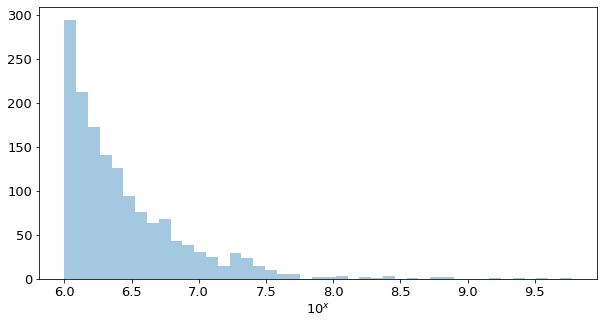

In [17]:
df = norm[(norm > 1e6) & (norm < np.inf)]
df = df.apply(np.log10)
sns.distplot(df, kde=False)
plt.xlabel("$10^x$")
plt.show()

In [18]:
norm[norm != np.inf].quantile([0.5, 0.95, 0.99])

0.50    1.013575e+05
0.95    1.054508e+06
0.99    5.802691e+06
dtype: float64

In [19]:
np.inf in norm

False

### Convert all levels

In [20]:
sales_conv = {}
norm_conv = {}

for level, groupby in ref.aggregation_levels.items():
    # select relevant quantities
    sales = sales_agg[level]
    weights = ref.weights[level]
    scales = ref.scales[level]
    
    # calculate series-wise normalization constant
    norm = scales / weights

    print("Level {} has {} series with zero weight (and subsequent norm inf)".format(
        level, weights[weights == 0].index.size))
    
    clip_norm = norm[norm != np.inf].quantile(0.99)
    print("Clipping {} series to 99th quantile normalisation of {}".format(
        (norm > clip_norm).sum(), clip_norm))
    norm.clip(upper=clip_norm, inplace=True)
    
    # calculate level-wise constant to normalise each level to [0, 1]
    norm = norm * (sales.T / norm).max().max()
    
    # calculate converted series
    sales_conv[level] = sales.T / norm
    
    # save normalisation
    norm_conv[level] = norm

Level 1 has 0 series with zero weight (and subsequent norm inf)
Clipping 0 series to 99th quantile normalisation of 34973137.91980881
Level 2 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 16755188.477792986
Level 3 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 6804607.656694104
Level 4 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 28293041.90757742
Level 5 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 25506535.460575987
Level 6 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 13355894.448057339
Level 7 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 11801136.841407014
Level 8 has 0 series with zero weight (and subsequent norm

### Set id similar to submission

In [21]:
def get_idx(idx, level, postfix=""):
    if level == 1:
        # total aggregates
        return "Total_X" + postfix
    elif (level >= 2 and level <= 5) or level == 10:
        # single-key aggregates
        return idx + "_X" + postfix
    elif level >= 6 and level <= 9:
        # two-key aggregates
        return idx[0] + "_" + idx[1] + postfix
    elif level == 11:
        # two-key aggregates reversed order
        return idx[1] + "_" + idx[0] + postfix
    elif level == 12:
        return idx.replace('_validation', '') + postfix
    assert False, "Index Error, level not recognised"

In [22]:
for level, groupby in ref.aggregation_levels.items():
    # convert indices
    idx = sales_conv[level].columns.map(lambda x: get_idx(x, level=level))
    # set new indices
    sales_conv[level].columns = idx
    norm_conv[level].index = idx

### Save results

In [23]:
for level, df in sales_conv.items():
    df.to_csv(os.environ['DATA_DIR'] + "/prep/converted_sales_level_{}.csv".format(level))
    norm_conv[level].to_csv(os.environ['DATA_DIR'] + "/prep/norm_level_{}.csv".format(level))

In [24]:
sales = pd.concat(sales_conv.values(), axis=1)
norm = pd.concat(norm_conv.values(), axis=1)
sales.head()

,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
d_1,0.570293,0.542355,0.503817,0.442196,0.297993,0.296446,0.379713,0.486090,0.265114,0.312363,...,0.0,0.003102,0.000557,0.0,0.002496,0.000000,0.0,0.000000,0.0,0.0
d_2,0.554878,0.527454,0.514066,0.408582,0.285488,0.258436,0.386764,0.531558,0.278701,0.319256,...,0.0,0.002437,0.000557,0.0,0.002496,0.000000,0.0,0.008478,0.0,0.0
d_3,0.415656,0.386201,0.361821,0.338945,0.193486,0.179955,0.303274,0.414598,0.188982,0.221460,...,0.0,0.001108,0.000557,0.0,0.001248,0.000717,0.0,0.000000,0.0,0.0
d_4,0.444126,0.422078,0.394011,0.343220,0.209632,0.197178,0.339090,0.430751,0.234205,0.239543,...,0.0,0.001329,0.000557,0.0,0.003120,0.000717,0.0,0.002826,0.0,0.0
d_5,0.334615,0.379209,0.315593,0.162617,0.180706,0.164768,0.305838,0.459468,0.175705,0.202079,...,0.0,0.001108,0.000557,0.0,0.001248,0.000000,0.0,0.002826,0.0,0.0


In [25]:
norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11
CA_1_FOODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17873.589493,NaN,NaN,NaN,NaN
CA_1_FOODS_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3440.135696,NaN,NaN,NaN
CA_1_FOODS_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2639.469012,NaN,NaN,NaN
CA_1_FOODS_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18982.463305,NaN,NaN,NaN
CA_1_HOBBIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2557.033980,NaN,NaN,NaN,NaN


In [26]:
sales.to_csv(os.environ['DATA_DIR'] + "/prep/converted_sales_all.csv")
norm.to_csv(os.environ['DATA_DIR'] + "/prep/norm_all.csv")